In [1]:
import pandas as pd
import numpy as np
import matplotlib as pls
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 

from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score

In [2]:
train_data=pd.read_csv("train_titanic.csv")

In [3]:
test_data=pd.read_csv("test_titanic.csv")

In [4]:
submission=pd.read_csv("titanic_submission.csv")

In [5]:
train_data.shape,test_data.shape,submission.shape

((891, 12), (418, 11), (418, 2))

In [6]:
train_data.duplicated().sum()

0

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
train_data.isna().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [9]:
train_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [10]:
data=pd.concat([train_data,test_data])

In [11]:
data.shape

(1309, 12)

#Extract titeles from names
def CustomTransformer(y):
    y.apply(lambda x:x.split(',')[1].split('.')[0])
    

In [12]:
cat_cols=data.drop(columns=['Survived','Cabin','Ticket','Name']).select_dtypes('object').columns
print(cat_cols)

num_cols=data.drop(columns=['Survived','Cabin','Ticket','Name']).select_dtypes(['int','float']).columns
print(num_cols)

#nam_cols=data.drop(columns=['PassengerId', 'Survived', 'Pclass','Sex', 'Age', 'SibSp','Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']).select_dtypes('object').columns
#print(nam_cols)









Index(['Sex', 'Embarked'], dtype='object')
Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')



name_encode=Pipeline(steps=[
    ('pre_preprocess_name', CustomTransformer())
])


In [13]:
#contains pipeline for one hot encoding



cat_encode = Pipeline(steps=[
    
    ('simp_cat', SimpleImputer(strategy='most_frequent')),
    ('ohe',OneHotEncoder(handle_unknown='ignore'))
    
    
])

#contains pipeline for simple imputer and min max scale encoding
num_encode = Pipeline(steps=[
    ('KNN_num',KNNImputer(n_neighbors=5)),
    #('mms', MinMaxScaler())
    ('standard_scaler',StandardScaler())
        
])

In [15]:
preprocess_encoding = ColumnTransformer(transformers=[
    ('categorical_preprocessing',cat_encode,cat_cols),
    ('numerical_preprocessing',num_encode,num_cols)
    ]
)

In [16]:
preprocess_encoding

ColumnTransformer(transformers=[('categorical_preprocessing',
                                 Pipeline(steps=[('simp_cat',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['Sex', 'Embarked'], dtype='object')),
                                ('numerical_preprocessing',
                                 Pipeline(steps=[('KNN_num', KNNImputer()),
                                                 ('standard_scaler',
                                                  StandardScaler())]),
                                 Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object'))])

In [17]:
pipe=Pipeline([
    ('preprocess', preprocess_encoding)
    
])

In [18]:
pipe.fit(data.drop(columns=['Survived','Cabin','Ticket','Name']))

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  Pipeline(steps=[('simp_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Sex', 'Embarked'], dtype='object')),
                                                 ('numerical_preprocessing',
                                                  Pipeline(steps=[('KNN_num',
                                                                   KNNImputer()),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
            

In [19]:
new_data=data.drop(columns=['Survived','Cabin','Ticket','Name']).head(5)
    

In [20]:
new_data

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,male,22.0,1,0,7.2500,S
1,2,1,female,38.0,1,0,71.2833,C
2,3,3,female,26.0,0,0,7.9250,S
3,4,1,female,35.0,1,0,53.1000,S
4,5,3,male,35.0,0,0,8.0500,S


In [21]:
out_new_data = pipe.transform(new_data)
out_new_data = pd.DataFrame(out_new_data)
#out_new_data

pipe_cat_cols= pipe['preprocess'].transformers_[0][1]['ohe'].get_feature_names(cat_cols)
ndcols = np.append(pipe_cat_cols, num_cols)
out_new_data.columns=ndcols
out_new_data

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,0.0,1.0,0.0,0.0,1.0,-1.730728,0.841916,-0.580204,0.481288,-0.445,-0.504052
1,1.0,0.0,1.0,0.0,0.0,-1.728082,-1.546098,0.632316,0.481288,-0.445,0.733790
2,1.0,0.0,0.0,0.0,1.0,-1.725435,0.841916,-0.277074,-0.479087,-0.445,-0.491004
3,1.0,0.0,0.0,0.0,1.0,-1.722789,-1.546098,0.404969,0.481288,-0.445,0.382285
4,0.0,1.0,0.0,0.0,1.0,-1.720143,0.841916,0.404969,-0.479087,-0.445,-0.488587


In [ ]:
#Add model to pipeline

In [23]:
from sklearn.naive_bayes import GaussianNB

In [24]:
pipe_enc_model = Pipeline([
    ('preprocess', preprocess_encoding),
    ('model', GaussianNB())
    
    ])

In [25]:
X=train_data.drop(columns=['Survived','Cabin','Ticket','Name'])
y=train_data["Survived"]

In [26]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.2, random_state=42)
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((712, 8), (179, 8), (712,), (179,))

In [27]:
pipe_enc_model.fit(train_X, train_y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_preprocessing',
                                                  Pipeline(steps=[('simp_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Sex', 'Embarked'], dtype='object')),
                                                 ('numerical_preprocessing',
                                                  Pipeline(steps=[('KNN_num',
                                                                   KNNImputer()),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
            

In [28]:
train_pred = pipe_enc_model.predict(train_X)
test_pred = pipe_enc_model.predict(test_X)

In [29]:
print("Train Result")
print(confusion_matrix(train_y, train_pred))
print(accuracy_score(train_y, train_pred))
print(classification_report(train_y, train_pred))

Train Result
[[374  70]
 [ 75 193]]
0.7963483146067416
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       444
           1       0.73      0.72      0.73       268

    accuracy                           0.80       712
   macro avg       0.78      0.78      0.78       712
weighted avg       0.80      0.80      0.80       712



In [30]:
print("Test Result")
print(confusion_matrix(test_y, test_pred))
print(accuracy_score(test_y, test_pred))
print(classification_report(test_y, test_pred))

Test Result
[[81 24]
 [16 58]]
0.776536312849162
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       105
           1       0.71      0.78      0.74        74

    accuracy                           0.78       179
   macro avg       0.77      0.78      0.77       179
weighted avg       0.78      0.78      0.78       179



In [31]:
test_X=test_data.drop(columns=['Cabin','Ticket','Name'])
pred_test_y=pipe_enc_model.predict(test_X)

In [32]:
submission['Survived'] = pred_test_y

In [33]:
submission.to_csv("submission_titanic_Naive_bayes.csv", index=False)

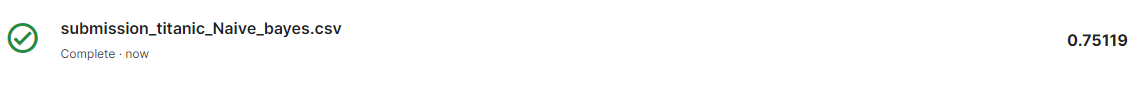